**Libraries**

In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install Pillow
!pip install keras
!pip install opencv-python


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil
import os
import random
import collections
import seaborn as sns
import zipfile
import os
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D

**Load Data**

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Garbage Classification.zip to Garbage Classification (1).zip


In [ ]:
# upload dataset as it is from kaggle
zip_path = "/content/Garbage Classification (1).zip"
extract_path = "/content/DataSet"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os

print(os.listdir("/content/DataSet"))


['one-indexed-files-notrash_test.txt', 'garbage classification', 'one-indexed-files.txt', 'Garbage classification', 'zero-indexed-files.txt', 'one-indexed-files-notrash_val.txt', 'one-indexed-files-notrash_train.txt']


**Split Data**

In [ ]:
from sklearn.model_selection import train_test_split

original_dataset = "/content/DataSet/Garbage classification/Garbage classification"
base_dir = "/content/garbage_dataset"

# create 3 directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# loop over original dataset (6 categories)
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if not os.path.isdir(class_path):
        continue

    # get all images from the category
    images = os.listdir(class_path)

    # split images in category into train, test, val
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)


    # loop over train_images and place them into a seperate class
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)


    for img in val_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_dir, class_name, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)


    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Data successfully split into:- Training: 70% (in", train_dir, "- Validation : 15% (in", val_dir, "- Testing : 15% (in", test_dir)

Data successfully split into:- Training: 70% (in /content/garbage_dataset/train - Validation : 15% (in /content/garbage_dataset/val - Testing : 15% (in /content/garbage_dataset/test


**Pre Processing**

Train Distribution:


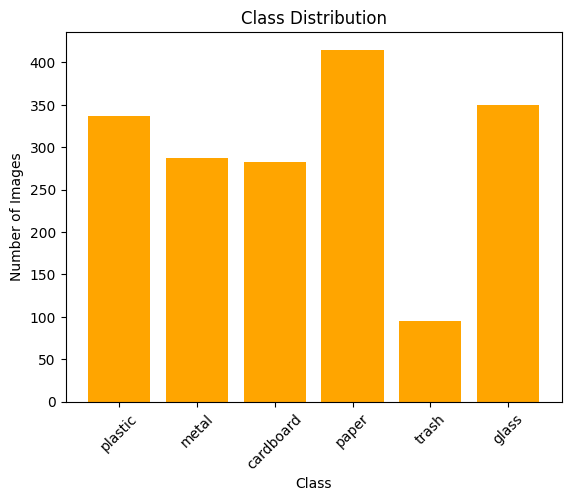

In [ ]:
# plot the distribution of train split
def plot_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    plt.bar(class_counts.keys(), class_counts.values(), color='orange')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

print("Train Distribution:")
plot_class_distribution('/content/garbage_dataset/train')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
import random
import numpy as np

train_dir = '/content/garbage_dataset/train'

# create a dictionary: key 'category', value 'number of images that belong to that category'
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
# get the max number to balance other categories by applying augmentation
max_images = max(class_counts.values())


aug = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# loop over each category and apply augmentation, until reaching to max_images
for class_name, count in class_counts.items():
    folder = os.path.join(train_dir, class_name)
    images = os.listdir(folder)
    current_count = len(images)

    while current_count < max_images:
        img_name = random.choice(images)
        img_path = os.path.join(folder, img_name)

        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        gen = aug.flow(image, batch_size=1)
        new_image = next(gen)[0].astype(np.uint8)

        save_path = os.path.join(folder, f"aug_{current_count}.jpg")
        Image.fromarray(new_image).save(save_path)

        current_count += 1


Train Distribution:


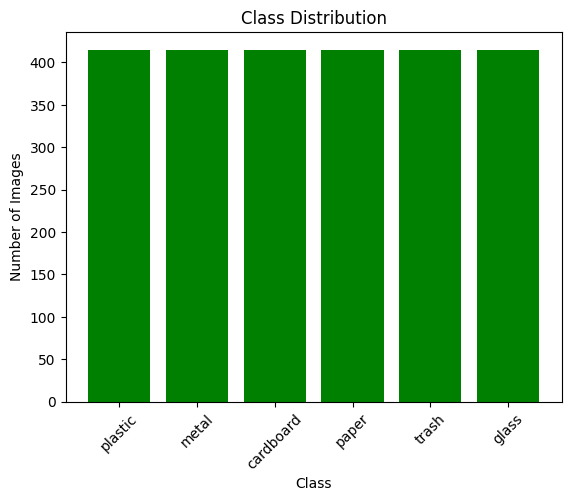

In [ ]:
# plot the distribution after balancing by upsampling - augmentation
def plot_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    plt.bar(class_counts.keys(), class_counts.values(), color='green')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

print("Train Distribution:")
plot_class_distribution('/content/garbage_dataset/train')

In [ ]:
# Applying augmentation to increase the dataset size
# do u have another reason?
def custom_normalization(img):
    img = img / 255.0
    img = img - 0.5
    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_normalization,
    validation_split=0.3,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=custom_normalization,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(
    preprocessing_function=custom_normalization
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1746 images belonging to 6 classes.
Found 744 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_labels = train_generator.classes

# check class weight? already balanced?
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}


**Build Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


base_model = DenseNet201(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(32, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(6, activation='softmax')(x)

model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,852,646 (71.92 MB)

 Trainable params: 529,830 (2.02 MB)

 Non-trainable params: 18,322,816 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

checkpoint_path = "best_model_Version_1.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[lr_schedule, checkpoint],
    class_weight=class_weight_dict
)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.1763 - loss: 8.7159
Epoch 1: val_accuracy improved from -inf to 0.31048, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.1766 - loss: 8.7117 - val_accuracy: 0.3105 - val_loss: 7.6683 - learning_rate: 1.0000e-04
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.2363 - loss: 7.7839
Epoch 2: val_accuracy improved from 0.31048 to 0.46237, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 588ms/step - accuracy: 0.2365 - loss: 7.7808 - val_accuracy: 0.4624 - val_loss: 6.9258 - learning_rate: 1.0000e-04
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.2402 - loss: 7.1402
Epoch 3: val_accuracy improved from 0.46237 to 0.54032, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 38s 542ms/step - accuracy: 0.2408 - loss: 7.1374 - val_accuracy: 0.5403 - val_loss: 6.3656 - learning_rate: 1.0000e-04
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.3398 - loss: 6.5588
Epoch 4: val_accuracy improved from 0.54032 to 0.60753, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 562ms/step - accuracy: 0.3400 - loss: 6.5567 - val_accuracy: 0.6075 - val_loss: 5.9175 - learning_rate: 1.0000e-04
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.3515 - loss: 6.2002
Epoch 5: val_accuracy improved from 0.60753 to 0.64651, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.3515 - loss: 6.1987 - val_accuracy: 0.6465 - val_loss: 5.5627 - learning_rate: 1.0000e-04
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.3757 - loss: 5.8503
Epoch 6: val_accuracy improved from 0.64651 to 0.67876, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - accuracy: 0.3761 - loss: 5.8488 - val_accuracy: 0.6788 - val_loss: 5.2818 - learning_rate: 1.0000e-04
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.3865 - loss: 5.6132
Epoch 7: val_accuracy improved from 0.67876 to 0.68280, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - accuracy: 0.3869 - loss: 5.6114 - val_accuracy: 0.6828 - val_loss: 5.0700 - learning_rate: 1.0000e-04
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.4219 - loss: 5.3440
Epoch 8: val_accuracy improved from 0.68280 to 0.70565, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.4221 - loss: 5.3431 - val_accuracy: 0.7056 - val_loss: 4.8870 - learning_rate: 1.0000e-04
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.4794 - loss: 5.1006
Epoch 9: val_accuracy improved from 0.70565 to 0.71640, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 549ms/step - accuracy: 0.4794 - loss: 5.1003 - val_accuracy: 0.7164 - val_loss: 4.7313 - learning_rate: 1.0000e-04
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.4988 - loss: 4.9763
Epoch 10: val_accuracy improved from 0.71640 to 0.73387, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.4988 - loss: 4.9759 - val_accuracy: 0.7339 - val_loss: 4.6029 - learning_rate: 1.0000e-04
Epoch 11/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5445 - loss: 4.8663
Epoch 11: val_accuracy improved from 0.73387 to 0.74328, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 559ms/step - accuracy: 0.5441 - loss: 4.8661 - val_accuracy: 0.7433 - val_loss: 4.4803 - learning_rate: 1.0000e-04
Epoch 12/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.5313 - loss: 4.7399
Epoch 12: val_accuracy did not improve from 0.74328
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 530ms/step - accuracy: 0.5314 - loss: 4.7394 - val_accuracy: 0.7419 - val_loss: 4.3738 - learning_rate: 1.0000e-04
Epoch 13/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5680 - loss: 4.6187
Epoch 13: val_accuracy improved from 0.74328 to 0.75403, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 545ms/step - accuracy: 0.5679 - loss: 4.6184 - val_accuracy: 0.7540 - val_loss: 4.2758 - learning_rate: 1.0000e-04
Epoch 14/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.5983 - loss: 4.4804
Epoch 14: val_accuracy improved from 0.75403 to 0.77151, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 558ms/step - accuracy: 0.5980 - loss: 4.4805 - val_accuracy: 0.7715 - val_loss: 4.1829 - learning_rate: 1.0000e-04
Epoch 15/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.5798 - loss: 4.4238
Epoch 15: val_accuracy improved from 0.77151 to 0.78763, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 544ms/step - accuracy: 0.5796 - loss: 4.4236 - val_accuracy: 0.7876 - val_loss: 4.0876 - learning_rate: 1.0000e-04
Epoch 16/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.5729 - loss: 4.3505
Epoch 16: val_accuracy did not improve from 0.78763
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 520ms/step - accuracy: 0.5732 - loss: 4.3498 - val_accuracy: 0.7876 - val_loss: 4.0054 - learning_rate: 1.0000e-04
Epoch 17/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6073 - loss: 4.2377
Epoch 17: val_accuracy improved from 0.78763 to 0.79167, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.6071 - loss: 4.2376 - val_accuracy: 0.7917 - val_loss: 3.9213 - learning_rate: 1.0000e-04
Epoch 18/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6096 - loss: 4.1884
Epoch 18: val_accuracy improved from 0.79167 to 0.79839, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.6097 - loss: 4.1877 - val_accuracy: 0.7984 - val_loss: 3.8400 - learning_rate: 1.0000e-04
Epoch 19/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6096 - loss: 4.1011
Epoch 19: val_accuracy did not improve from 0.79839
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 524ms/step - accuracy: 0.6100 - loss: 4.1000 - val_accuracy: 0.7984 - val_loss: 3.7549 - learning_rate: 1.0000e-04
Epoch 20/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6151 - loss: 4.0080
Epoch 20: val_accuracy improved from 0.79839 to 0.79973, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 542ms/step - accuracy: 0.6152 - loss: 4.0077 - val_accuracy: 0.7997 - val_loss: 3.6894 - learning_rate: 1.0000e-04
Epoch 21/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6139 - loss: 3.9207
Epoch 21: val_accuracy did not improve from 0.79973
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.6143 - loss: 3.9200 - val_accuracy: 0.7984 - val_loss: 3.6185 - learning_rate: 1.0000e-04
Epoch 22/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6359 - loss: 3.8565
Epoch 22: val_accuracy improved from 0.79973 to 0.80242, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.6363 - loss: 3.8558 - val_accuracy: 0.8024 - val_loss: 3.5421 - learning_rate: 1.0000e-04
Epoch 23/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6560 - loss: 3.7580
Epoch 23: val_accuracy improved from 0.80242 to 0.80511, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.6561 - loss: 3.7576 - val_accuracy: 0.8051 - val_loss: 3.4716 - learning_rate: 1.0000e-04
Epoch 24/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6673 - loss: 3.6633
Epoch 24: val_accuracy improved from 0.80511 to 0.80645, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.6672 - loss: 3.6635 - val_accuracy: 0.8065 - val_loss: 3.4054 - learning_rate: 1.0000e-04
Epoch 25/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.6515 - loss: 3.6238
Epoch 25: val_accuracy did not improve from 0.80645
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 532ms/step - accuracy: 0.6517 - loss: 3.6233 - val_accuracy: 0.8011 - val_loss: 3.3353 - learning_rate: 1.0000e-04
Epoch 26/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6899 - loss: 3.5336
Epoch 26: val_accuracy improved from 0.80645 to 0.80914, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.6899 - loss: 3.5330 - val_accuracy: 0.8091 - val_loss: 3.2536 - learning_rate: 1.0000e-04
Epoch 27/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.7041 - loss: 3.4774
Epoch 27: val_accuracy improved from 0.80914 to 0.81855, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.7040 - loss: 3.4767 - val_accuracy: 0.8185 - val_loss: 3.1860 - learning_rate: 1.0000e-04
Epoch 28/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7012 - loss: 3.3566
Epoch 28: val_accuracy improved from 0.81855 to 0.81989, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.7014 - loss: 3.3562 - val_accuracy: 0.8199 - val_loss: 3.1106 - learning_rate: 1.0000e-04
Epoch 29/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7427 - loss: 3.2370
Epoch 29: val_accuracy did not improve from 0.81989
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 523ms/step - accuracy: 0.7422 - loss: 3.2376 - val_accuracy: 0.8172 - val_loss: 3.0489 - learning_rate: 1.0000e-04
Epoch 30/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7039 - loss: 3.2377
Epoch 30: val_accuracy improved from 0.81989 to 0.82527, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.7040 - loss: 3.2374 - val_accuracy: 0.8253 - val_loss: 2.9848 - learning_rate: 1.0000e-04
Epoch 31/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7347 - loss: 3.1538
Epoch 31: val_accuracy did not improve from 0.82527
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.7344 - loss: 3.1542 - val_accuracy: 0.8145 - val_loss: 2.9221 - learning_rate: 1.0000e-04
Epoch 32/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7101 - loss: 3.1204
Epoch 32: val_accuracy did not improve from 0.82527
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 532ms/step - accuracy: 0.7104 - loss: 3.1198 - val_accuracy: 0.8199 - val_loss: 2.8601 - learning_rate: 1.0000e-04
Epoch 33/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7475 - loss: 3.0162
Epoch 33: val_accuracy improved from 0.82527 to 0.82930, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - accuracy: 0.7473 - loss: 3.0162 - val_accuracy: 0.8293 - val_loss: 2.7948 - learning_rate: 1.0000e-04
Epoch 34/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7449 - loss: 2.9688
Epoch 34: val_accuracy did not improve from 0.82930
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 521ms/step - accuracy: 0.7446 - loss: 2.9693 - val_accuracy: 0.8293 - val_loss: 2.7263 - learning_rate: 1.0000e-04
Epoch 35/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7503 - loss: 2.8958
Epoch 35: val_accuracy improved from 0.82930 to 0.84005, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 542ms/step - accuracy: 0.7502 - loss: 2.8957 - val_accuracy: 0.8401 - val_loss: 2.6644 - learning_rate: 1.0000e-04
Epoch 36/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7665 - loss: 2.8276
Epoch 36: val_accuracy improved from 0.84005 to 0.84677, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.7664 - loss: 2.8275 - val_accuracy: 0.8468 - val_loss: 2.6053 - learning_rate: 1.0000e-04
Epoch 37/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7654 - loss: 2.7750
Epoch 37: val_accuracy improved from 0.84677 to 0.84812, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.7653 - loss: 2.7750 - val_accuracy: 0.8481 - val_loss: 2.5582 - learning_rate: 1.0000e-04
Epoch 38/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7569 - loss: 2.7335
Epoch 38: val_accuracy did not improve from 0.84812
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 562ms/step - accuracy: 0.7570 - loss: 2.7330 - val_accuracy: 0.8468 - val_loss: 2.4981 - learning_rate: 1.0000e-04
Epoch 39/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7671 - loss: 2.6785
Epoch 39: val_accuracy improved from 0.84812 to 0.85484, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.7671 - loss: 2.6780 - val_accuracy: 0.8548 - val_loss: 2.4431 - learning_rate: 1.0000e-04
Epoch 40/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.7928 - loss: 2.5947
Epoch 40: val_accuracy did not improve from 0.85484
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.7926 - loss: 2.5947 - val_accuracy: 0.8508 - val_loss: 2.3894 - learning_rate: 1.0000e-04
Epoch 41/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7431 - loss: 2.6428
Epoch 41: val_accuracy did not improve from 0.85484
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.7435 - loss: 2.6417 - val_accuracy: 0.8535 - val_loss: 2.3300 - learning_rate: 1.0000e-04
Epoch 42/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7784 - loss: 2.4767
Epoch 42: val_accuracy improved from 0.85484 to 0.85618, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.7786 - loss: 2.4764 - val_accuracy: 0.8562 - val_loss: 2.2689 - learning_rate: 1.0000e-04
Epoch 43/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7899 - loss: 2.4406
Epoch 43: val_accuracy did not improve from 0.85618
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 533ms/step - accuracy: 0.7898 - loss: 2.4404 - val_accuracy: 0.8548 - val_loss: 2.2227 - learning_rate: 1.0000e-04
Epoch 44/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7857 - loss: 2.3880
Epoch 44: val_accuracy improved from 0.85618 to 0.86290, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - accuracy: 0.7857 - loss: 2.3877 - val_accuracy: 0.8629 - val_loss: 2.1755 - learning_rate: 1.0000e-04
Epoch 45/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7953 - loss: 2.3401
Epoch 45: val_accuracy improved from 0.86290 to 0.86962, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.7953 - loss: 2.3401 - val_accuracy: 0.8696 - val_loss: 2.1253 - learning_rate: 1.0000e-04
Epoch 46/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7979 - loss: 2.2796
Epoch 46: val_accuracy improved from 0.86962 to 0.87500, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 550ms/step - accuracy: 0.7977 - loss: 2.2798 - val_accuracy: 0.8750 - val_loss: 2.0780 - learning_rate: 1.0000e-04
Epoch 47/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8048 - loss: 2.2506
Epoch 47: val_accuracy improved from 0.87500 to 0.88038, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.8047 - loss: 2.2506 - val_accuracy: 0.8804 - val_loss: 2.0310 - learning_rate: 1.0000e-04
Epoch 48/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7915 - loss: 2.2303
Epoch 48: val_accuracy improved from 0.88038 to 0.88172, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 549ms/step - accuracy: 0.7918 - loss: 2.2298 - val_accuracy: 0.8817 - val_loss: 1.9830 - learning_rate: 1.0000e-04
Epoch 49/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.7975 - loss: 2.1569
Epoch 49: val_accuracy improved from 0.88172 to 0.88441, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.7975 - loss: 2.1569 - val_accuracy: 0.8844 - val_loss: 1.9437 - learning_rate: 1.0000e-04
Epoch 50/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8187 - loss: 2.0828
Epoch 50: val_accuracy did not improve from 0.88441
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 523ms/step - accuracy: 0.8188 - loss: 2.0826 - val_accuracy: 0.8844 - val_loss: 1.9115 - learning_rate: 1.0000e-04
Epoch 51/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8047 - loss: 2.0654
Epoch 51: val_accuracy improved from 0.88441 to 0.88710, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 554ms/step - accuracy: 0.8049 - loss: 2.0650 - val_accuracy: 0.8871 - val_loss: 1.8581 - learning_rate: 1.0000e-04
Epoch 52/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8442 - loss: 1.9652
Epoch 52: val_accuracy did not improve from 0.88710
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 526ms/step - accuracy: 0.8439 - loss: 1.9654 - val_accuracy: 0.8831 - val_loss: 1.8179 - learning_rate: 1.0000e-04
Epoch 53/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8135 - loss: 1.9893
Epoch 53: val_accuracy did not improve from 0.88710
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 569ms/step - accuracy: 0.8136 - loss: 1.9892 - val_accuracy: 0.8844 - val_loss: 1.7866 - learning_rate: 1.0000e-04
Epoch 54/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8017 - loss: 1.9705
Epoch 54: val_accuracy did not improve from 0.88710
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.8017 - loss: 1.9703 - val_accuracy: 0.8871 - val_loss: 1.7535 - learning_rate: 1.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 602ms/step - accuracy: 0.8163 - loss: 1.9411 - val_accuracy: 0.8898 - val_loss: 1.7218 - learning_rate: 1.0000e-04
Epoch 56/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8264 - loss: 1.8814
Epoch 56: val_accuracy improved from 0.88978 to 0.89516, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.8264 - loss: 1.8815 - val_accuracy: 0.8952 - val_loss: 1.6704 - learning_rate: 1.0000e-04
Epoch 57/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8371 - loss: 1.8402
Epoch 57: val_accuracy did not improve from 0.89516
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.8370 - loss: 1.8399 - val_accuracy: 0.8938 - val_loss: 1.6444 - learning_rate: 1.0000e-04
Epoch 58/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8282 - loss: 1.8164
Epoch 58: val_accuracy did not improve from 0.89516
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.8283 - loss: 1.8160 - val_accuracy: 0.8898 - val_loss: 1.6163 - learning_rate: 1.0000e-04
Epoch 59/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8302 - loss: 1.7655
Epoch 59: val_accuracy improved from 0.89516 to 0.90591, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - accuracy: 0.8302 - loss: 1.7654 - val_accuracy: 0.9059 - val_loss: 1.5659 - learning_rate: 1.0000e-04
Epoch 60/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8350 - loss: 1.7211
Epoch 60: val_accuracy did not improve from 0.90591
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.8351 - loss: 1.7209 - val_accuracy: 0.9032 - val_loss: 1.5369 - learning_rate: 1.0000e-04
Epoch 61/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8556 - loss: 1.6485
Epoch 61: val_accuracy did not improve from 0.90591
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.8552 - loss: 1.6493 - val_accuracy: 0.8978 - val_loss: 1.5097 - learning_rate: 1.0000e-04
Epoch 62/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8523 - loss: 1.6363
Epoch 62: val_accuracy improved from 0.90591 to 0.91263, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.8525 - loss: 1.6361 - val_accuracy: 0.9126 - val_loss: 1.4638 - learning_rate: 1.0000e-04
Epoch 63/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8652 - loss: 1.5906
Epoch 63: val_accuracy did not improve from 0.91263
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 523ms/step - accuracy: 0.8652 - loss: 1.5904 - val_accuracy: 0.9059 - val_loss: 1.4408 - learning_rate: 1.0000e-04
Epoch 64/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8475 - loss: 1.6120
Epoch 64: val_accuracy did not improve from 0.91263
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.8476 - loss: 1.6117 - val_accuracy: 0.9073 - val_loss: 1.4181 - learning_rate: 1.0000e-04
Epoch 65/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8321 - loss: 1.6104
Epoch 65: val_accuracy did not improve from 0.91263
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 521ms/step - accuracy: 0.8323 - loss: 1.6099 - val_accuracy: 0.9059 - val_loss: 1.3868 - learning_rate: 1.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 545ms/step - accuracy: 0.8694 - loss: 1.4963 - val_accuracy: 0.9220 - val_loss: 1.3156 - learning_rate: 1.0000e-04
Epoch 68/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8499 - loss: 1.4882
Epoch 68: val_accuracy did not improve from 0.92204
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.8497 - loss: 1.4884 - val_accuracy: 0.9032 - val_loss: 1.3137 - learning_rate: 1.0000e-04
Epoch 69/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8590 - loss: 1.4691
Epoch 69: val_accuracy did not improve from 0.92204
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.8589 - loss: 1.4689 - val_accuracy: 0.9220 - val_loss: 1.2767 - learning_rate: 1.0000e-04
Epoch 70/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8553 - loss: 1.4513
Epoch 70: val_accuracy did not improve from 0.92204
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 530ms/step - accuracy: 0.8554 - loss: 1.4508 - val_accuracy: 0.9180 - val_loss: 1.2530 - learning_rate: 1.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.8812 - loss: 1.1096 - val_accuracy: 0.9315 - val_loss: 0.9556 - learning_rate: 1.0000e-04
Epoch 86/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9037 - loss: 1.0575
Epoch 86: val_accuracy did not improve from 0.93145
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.9036 - loss: 1.0580 - val_accuracy: 0.9180 - val_loss: 0.9542 - learning_rate: 1.0000e-04
Epoch 87/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8973 - loss: 1.0558
Epoch 87: val_accuracy did not improve from 0.93145
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.8971 - loss: 1.0561 - val_accuracy: 0.9167 - val_loss: 0.9543 - learning_rate: 1.0000e-04
Epoch 88/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8974 - loss: 1.0495
Epoch 88: val_accuracy did not improve from 0.93145
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 574ms/step - accuracy: 0.8972 - loss: 1.0502 - val_accuracy: 0.9301 - val_loss: 0.9258 - learning_rate: 1.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 544ms/step - accuracy: 0.9011 - loss: 0.9511 - val_accuracy: 0.9395 - val_loss: 0.8141 - learning_rate: 1.0000e-04
Epoch 96/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8840 - loss: 0.9566
Epoch 96: val_accuracy did not improve from 0.93952
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 566ms/step - accuracy: 0.8840 - loss: 0.9567 - val_accuracy: 0.9288 - val_loss: 0.8140 - learning_rate: 1.0000e-04
Epoch 97/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8919 - loss: 0.9407
Epoch 97: val_accuracy did not improve from 0.93952
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.8918 - loss: 0.9408 - val_accuracy: 0.9382 - val_loss: 0.8029 - learning_rate: 1.0000e-04
Epoch 98/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8855 - loss: 0.9173
Epoch 98: val_accuracy did not improve from 0.93952
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 524ms/step - accuracy: 0.8856 - loss: 0.9174 - val_accuracy: 0.9220 - val_loss: 0.8149 - learning_rate: 1.0000e

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 544ms/step - accuracy: 0.9179 - loss: 0.7375 - val_accuracy: 0.9409 - val_loss: 0.6413 - learning_rate: 1.0000e-04
Epoch 116/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8929 - loss: 0.7929
Epoch 116: val_accuracy did not improve from 0.94086
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 536ms/step - accuracy: 0.8931 - loss: 0.7922 - val_accuracy: 0.9341 - val_loss: 0.6468 - learning_rate: 1.0000e-04
Epoch 117/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9085 - loss: 0.7627
Epoch 117: val_accuracy did not improve from 0.94086
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.9086 - loss: 0.7625 - val_accuracy: 0.9261 - val_loss: 0.6562 - learning_rate: 1.0000e-04
Epoch 118/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9080 - loss: 0.7419
Epoch 118: val_accuracy did not improve from 0.94086
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.9080 - loss: 0.7419 - val_accuracy: 0.9382 - val_loss: 0.6243 - learning_rate: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 540ms/step - accuracy: 0.9301 - loss: 0.6449 - val_accuracy: 0.9462 - val_loss: 0.5671 - learning_rate: 1.0000e-04
Epoch 130/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9223 - loss: 0.6366
Epoch 130: val_accuracy did not improve from 0.94624
55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 631ms/step - accuracy: 0.9222 - loss: 0.6368 - val_accuracy: 0.9341 - val_loss: 0.5768 - learning_rate: 1.0000e-04
Epoch 131/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9324 - loss: 0.6252
Epoch 131: val_accuracy did not improve from 0.94624
55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.9323 - loss: 0.6256 - val_accuracy: 0.9274 - val_loss: 0.5818 - learning_rate: 1.0000e-04
Epoch 132/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9052 - loss: 0.6831
Epoch 132: val_accuracy did not improve from 0.94624
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 530ms/step - accuracy: 0.9053 - loss: 0.6829 - val_accuracy: 0.9328 - val_loss: 0.5694 - learning_rate: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 544ms/step - accuracy: 0.9364 - loss: 0.5851 - val_accuracy: 0.9476 - val_loss: 0.5284 - learning_rate: 1.0000e-04
Epoch 138/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9332 - loss: 0.5952
Epoch 138: val_accuracy did not improve from 0.94758
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 522ms/step - accuracy: 0.9332 - loss: 0.5951 - val_accuracy: 0.9409 - val_loss: 0.5324 - learning_rate: 1.0000e-04
Epoch 139/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9292 - loss: 0.5980
Epoch 139: val_accuracy did not improve from 0.94758
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 526ms/step - accuracy: 0.9292 - loss: 0.5980 - val_accuracy: 0.9449 - val_loss: 0.5309 - learning_rate: 1.0000e-04
Epoch 140/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9235 - loss: 0.6019
Epoch 140: val_accuracy did not improve from 0.94758
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 588ms/step - accuracy: 0.9234 - loss: 0.6021 - val_accuracy: 0.9435 - val_loss: 0.5206 - learning_rate: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.9309 - loss: 0.5885 - val_accuracy: 0.9489 - val_loss: 0.4691 - learning_rate: 1.0000e-04
Epoch 151/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9263 - loss: 0.5367
Epoch 151: val_accuracy improved from 0.94892 to 0.95296, saving model to best_model_Version_1.h5


55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 554ms/step - accuracy: 0.9263 - loss: 0.5370 - val_accuracy: 0.9530 - val_loss: 0.4698 - learning_rate: 1.0000e-04
Epoch 152/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9312 - loss: 0.5370
Epoch 152: val_accuracy did not improve from 0.95296
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 527ms/step - accuracy: 0.9312 - loss: 0.5372 - val_accuracy: 0.9395 - val_loss: 0.4974 - learning_rate: 1.0000e-04
Epoch 153/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9201 - loss: 0.5912
Epoch 153: val_accuracy did not improve from 0.95296
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 532ms/step - accuracy: 0.9202 - loss: 0.5908 - val_accuracy: 0.9449 - val_loss: 0.4907 - learning_rate: 1.0000e-04
Epoch 154/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9269 - loss: 0.5490
Epoch 154: val_accuracy did not improve from 0.95296
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.9269 - loss: 0.5490 - val_accuracy: 0.9382 - val_loss: 0.4876 - learning_rate: 1

55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 561ms/step - accuracy: 0.9448 - loss: 0.4342 - val_accuracy: 0.9543 - val_loss: 0.4084 - learning_rate: 5.0000e-05
Epoch 185/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9496 - loss: 0.4423
Epoch 185: val_accuracy did not improve from 0.95430
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.9496 - loss: 0.4422 - val_accuracy: 0.9489 - val_loss: 0.4059 - learning_rate: 5.0000e-05
Epoch 186/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9465 - loss: 0.4372
Epoch 186: val_accuracy did not improve from 0.95430
55/55 ━━━━━━━━━━━━━━━━━━━━ 41s 529ms/step - accuracy: 0.9465 - loss: 0.4371 - val_accuracy: 0.9530 - val_loss: 0.4020 - learning_rate: 5.0000e-05
Epoch 187/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9426 - loss: 0.4480
Epoch 187: val_accuracy did not improve from 0.95430
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.9426 - loss: 0.4480 - val_accuracy: 0.9530 - val_loss: 0.4101 - learning_rate: 5

55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 599ms/step - accuracy: 0.9505 - loss: 0.4149 - val_accuracy: 0.9556 - val_loss: 0.3972 - learning_rate: 5.0000e-05
Epoch 193/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9634 - loss: 0.3940
Epoch 193: val_accuracy did not improve from 0.95565
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 533ms/step - accuracy: 0.9633 - loss: 0.3943 - val_accuracy: 0.9556 - val_loss: 0.3906 - learning_rate: 5.0000e-05
Epoch 194/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9408 - loss: 0.4528
Epoch 194: val_accuracy did not improve from 0.95565
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 530ms/step - accuracy: 0.9409 - loss: 0.4527 - val_accuracy: 0.9503 - val_loss: 0.3997 - learning_rate: 5.0000e-05
Epoch 195/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9372 - loss: 0.4134
Epoch 195: val_accuracy did not improve from 0.95565
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 526ms/step - accuracy: 0.9374 - loss: 0.4132 - val_accuracy: 0.9530 - val_loss: 0.3974 - learning_rate: 5

In [ ]:
from tensorflow.keras.models import load_model

#load the best weights
model = load_model("best_model_Version_1.h5")

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.save('garbage_classification_model_one.h5')

In [ ]:
# should reset the genertor before
train_loss, train_accu = model.evaluate(train_generator)
val_loss, val_accu = model.evaluate(val_generator)
test_loss, test_accu = model.evaluate(test_generator)

print("final train accuracy = {:.2f}, validation accuracy = {:.2f}, testing accuracy = {:.2f}"
      .format(train_accu*100, val_accu*100, test_accu*100))

55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 716ms/step - accuracy: 0.9945 - loss: 0.2725
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 632ms/step - accuracy: 0.9741 - loss: 0.3438
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9420 - loss: 0.4534
final train accuracy = 99.43, validation accuracy = 95.56, testing accuracy = 91.64


**Evaluation**

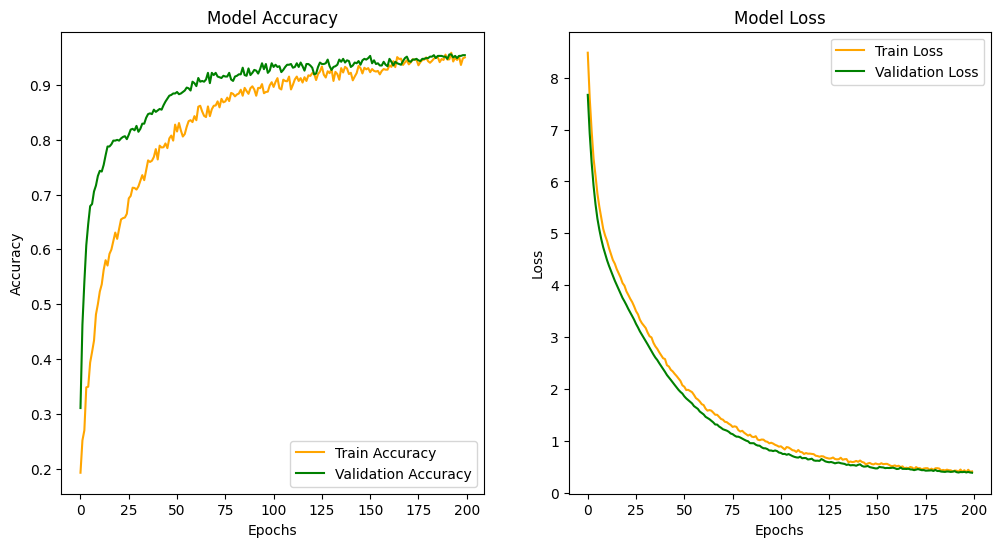

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 486ms/step - accuracy: 0.9972 - loss: 0.2721
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9741 - loss: 0.3438
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9420 - loss: 0.4534
final train accuracy = 99.37, validation accuracy = 95.56, testing accuracy = 91.64
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step


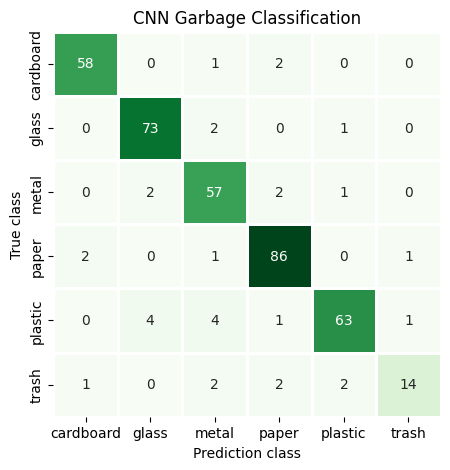

In [ ]:
# Resets the generator's internal batch index to the beginning of the data/ start from 1st batch
# train_generator.reset()  val_generator.reset() test_generator.reset()
train_loss, train_accu = model.evaluate(train_generator)
val_loss, val_accu = model.evaluate(val_generator)
test_loss, test_accu = model.evaluate(test_generator)

print("final train accuracy = {:.2f}, validation accuracy = {:.2f}, testing accuracy = {:.2f}"
      .format(train_accu*100, val_accu*100, test_accu*100))


Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

label = ['cardboard','glass','metal','paper','plastic','trash']
labels = {0 : 'cardboard', 1 : 'glass', 2 : 'metal', 3 : 'paper', 4 : 'plastic',5 :'trash'}


cm = confusion_matrix(test_generator.classes, y_pred)
cm_df = pd.DataFrame(cm, index = label,
                     columns = label
                    )


plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot = True,cmap='Greens',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Garbage Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

**Test**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


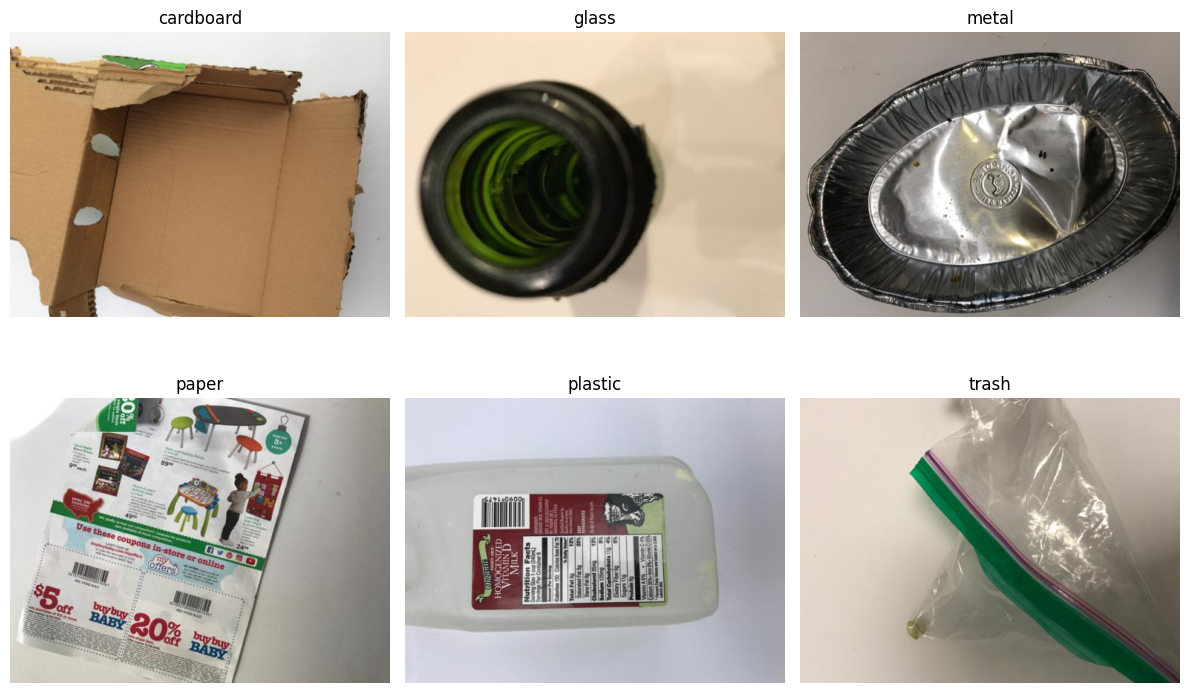

In [ ]:
def choose_image_and_predict(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    img = np.stack([img] * 3, axis=-1)
    pred = model.predict(img)
    label = np.argmax(pred, axis=1)[0]
    return labels[label]

images = ["cardboard.jpg", "glass.jpg", "metal.jpg", "paper.jpg", "plastic.jpg", "trash.jpg"]

fig = plt.figure(figsize=(12, 8))
rows, columns = 2, 3

for idx, image_path in enumerate(images):
    fig.add_subplot(rows, columns, idx + 1)
    plt.imshow(load_img(image_path))
    plt.axis('off')
    title = choose_image_and_predict(image_path)
    plt.title(title, fontsize=12)

plt.tight_layout()
plt.show()
